In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd

# Setup Radar Parameters

In [44]:
# Radar parameters (modify with your actual values)
chirp_duration = 0.02  # Carrier frequency in Hz (e.g., 24 GHz)
c = 3e8    # Speed of light in m/s
cutoff_distance = 30  # Velocity cutoff in m/s
bandwidth = 250e6
sampling_freq = 100000

# Select the recording file for analysis

In [4]:
print(os.listdir("../ductenna_backend/recordings"))

['recording_2025-03-23_16-29-12.png', 'recording_2025-03-23_16-26-49.csv', 'recording_2025-03-23_16-27-35.csv', 'recording_2025-03-23_16-27-35.csv.png', 'recording_2025-03-23_16-28-19.csv.png', 'recording_2025-03-23_16-28-19.png', 'recording_2025-03-23_16-28-06.csv', 'car_10.42m.csv', 'recording_2025-03-23_16-26-49.csv.png', 'recording_2025-03-23_16-29-12.csv.png', 'car_10.42m.png', 'recording_2025-03-23_16-28-19.csv', 'recording_2025-03-23_16-28-06.png', 'recording_2025-03-23_16-28-06.csv.png', 'recording_2025-03-23_16-26-49.png', 'recording_2025-03-23_16-27-35.png', 'recording_2025-03-23_16-29-12.csv']


In [7]:
# Read the CSV file
df = pd.read_csv('../ductenna_backend/recordings/car_10.42m.csv')

# print the column names
print(df.columns)

# Group by 'Acquisition Time'
grouped = df.groupby('Acquisition Time')

# Create a dictionary: key is the acquisition time, value is a list of rows with the other columns
data_dict = {
    acquisition_time: group[['Reading Time', 'Channel 1', 'Channel 2']]
    for acquisition_time, group in grouped
}

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


8192


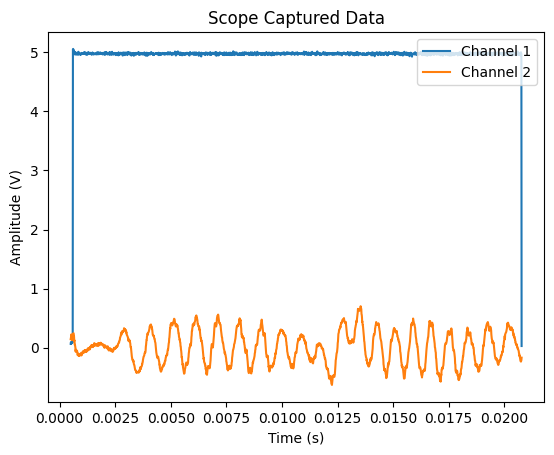

In [50]:
# Get acquisition time from middle of list
acquisition_time = list(data_dict.keys())[(len(data_dict) // 2)-5]
# Get the data for the acquisition time
data = data_dict[acquisition_time]
print(len(data))
data = data[50:2079]
#plot channel 1 and channel 2
plt.plot(data['Reading Time'], data['Channel 1'], label='Channel 1')
plt.plot(data['Reading Time'], data['Channel 2'], label='Channel 2')
plt.title('Scope Captured Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
# add legend to top right
plt.legend(loc='upper right')
plt.show()

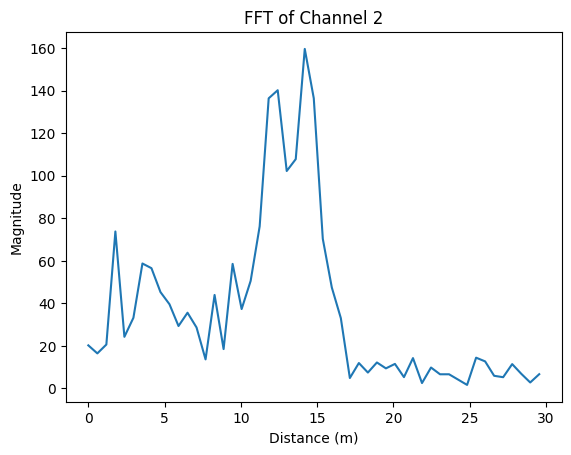

In [51]:
# take fft of data
n = len(data)
f = np.fft.fftfreq(n, 1/sampling_freq)
f = f[:n//2]
fft2 = np.fft.fft(data['Channel 2'])[:n//2]
distances = (f * c*chirp_duration) / (2 * bandwidth)
# crop to cutoff distance
mask = distances < cutoff_distance
distances = distances[mask]
fft2 = fft2[mask]
# plot fft
plt.plot(distances, np.abs(fft2))
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.title('FFT of Channel 2')
plt.show()

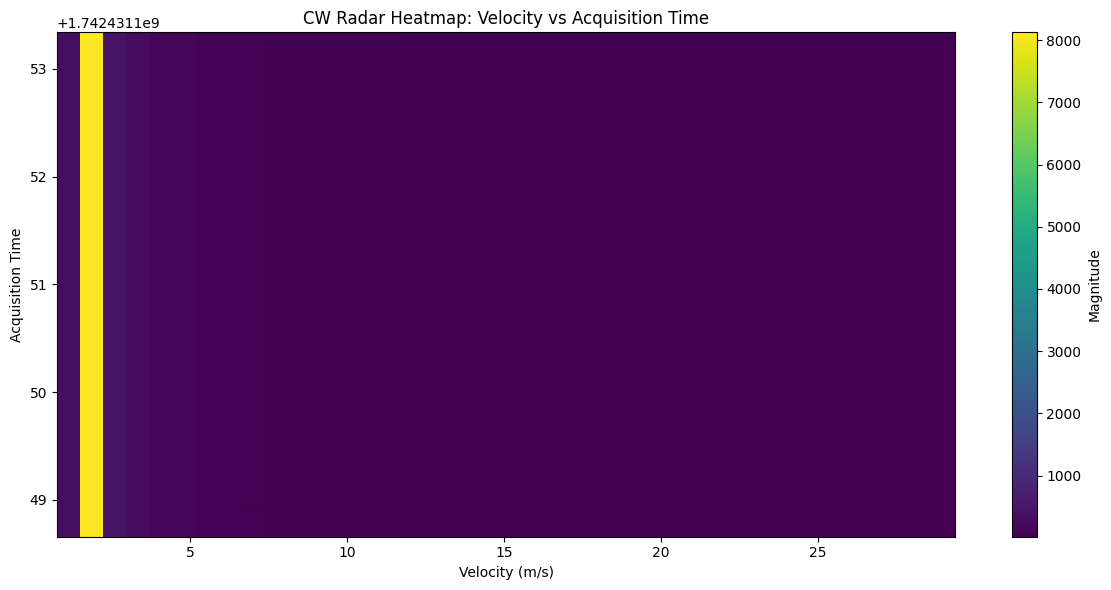

In [53]:
# Prepare lists for heatmap axes
velocities = None
times = []
heatmap_data = []

# CW radar: v = (f_d * c) / (2 * fc)
def freq_to_velocity(f_d, fc=fc, c=c):
    return (f_d * c) / (2 * fc)

# Process each acquisition group
for acquisition_time, data in data_dict.items():
    signal = data['Channel 2'].values  # Use 'Ch1', or change to 'CH2' if preferred

    # # Detrend or preprocess if needed
    # signal = signal - np.mean(signal)

    # Apply FFT
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=np.mean(np.diff(data['Reading Time'])))

    # Only take positive frequencies
    pos_mask = fft_freqs > 0
    freqs = fft_freqs[pos_mask]
    magnitudes = np.abs(fft_vals[pos_mask])

    # Convert frequencies to velocity
    vels = freq_to_velocity(freqs)

    # Trim to cutoff velocity
    vel_mask = vels <= cutoff_velocity
    vels_trimmed = vels[vel_mask]
    mags_trimmed = magnitudes[vel_mask]

    # Store for heatmap
    if velocities is None:
        velocities = vels_trimmed
    heatmap_data.append(mags_trimmed)
    times.append(acquisition_time)

# Create heatmap
heatmap_array = np.array(heatmap_data)

plt.figure(figsize=(12, 6))
plt.imshow(
    heatmap_array,
    aspect='auto',
    extent=[min(velocities), max(velocities), min(times), max(times)],
    origin='lower'
)
plt.colorbar(label='Magnitude')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Acquisition Time')
plt.title('CW Radar Heatmap: Velocity vs Acquisition Time')
plt.tight_layout()
plt.show()

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


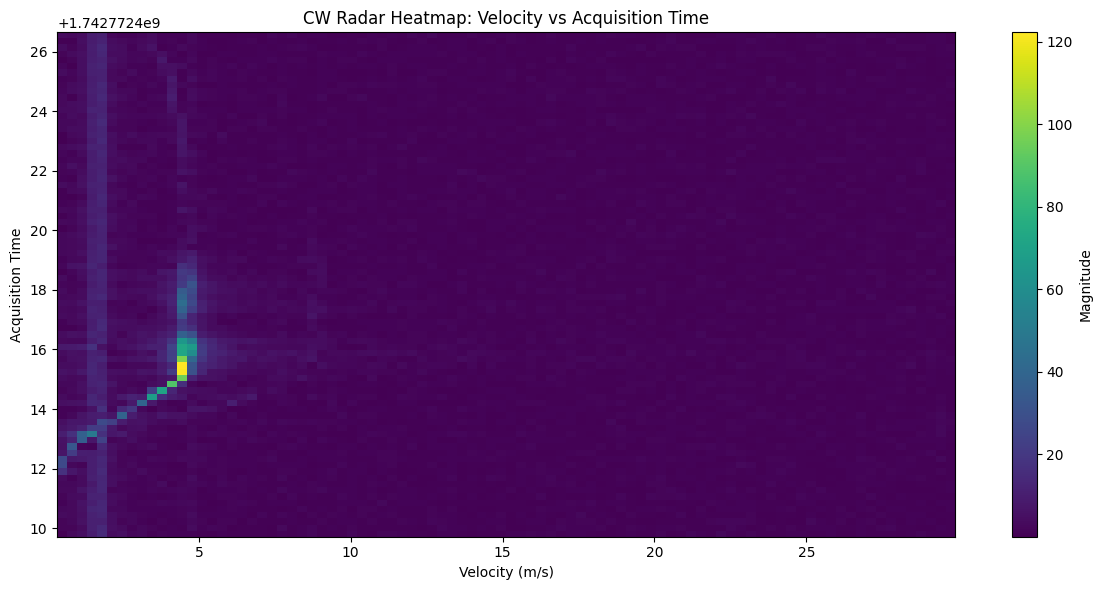

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


<Figure size 640x480 with 0 Axes>

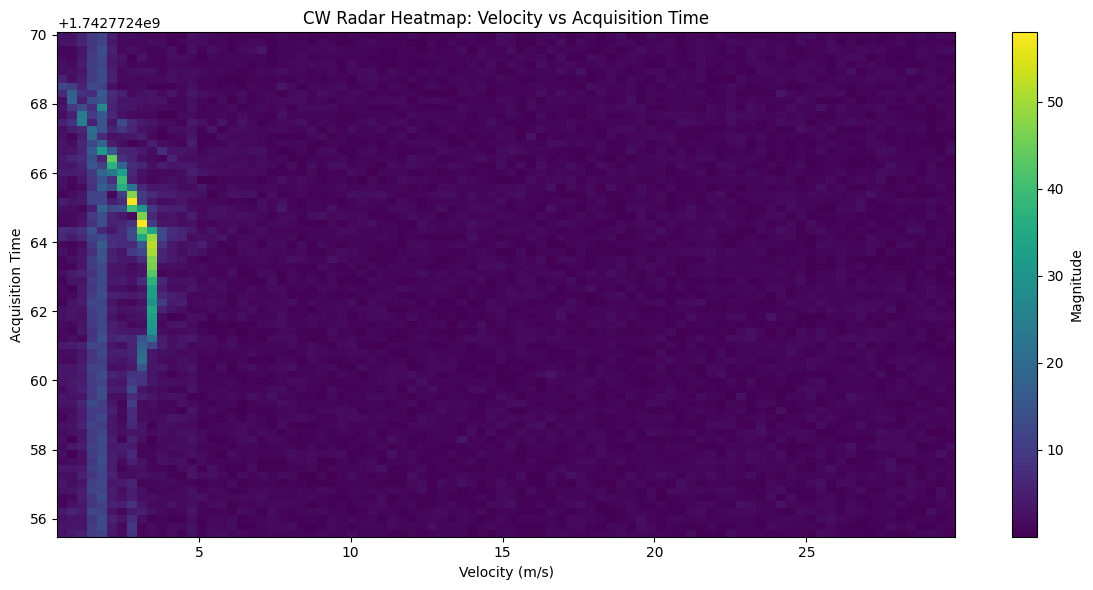

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


<Figure size 640x480 with 0 Axes>

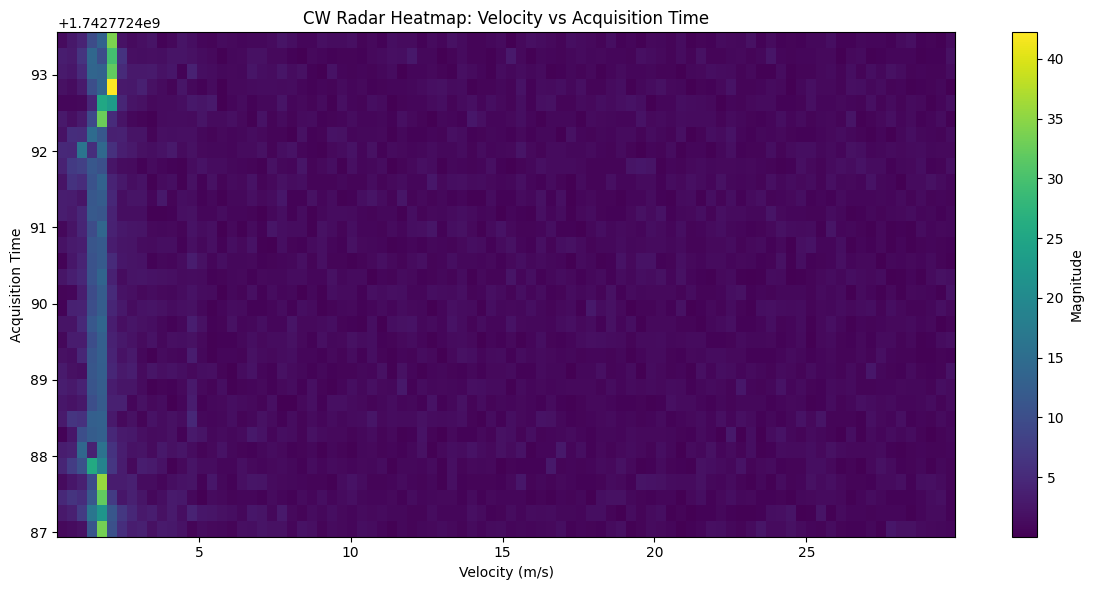

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


<Figure size 640x480 with 0 Axes>

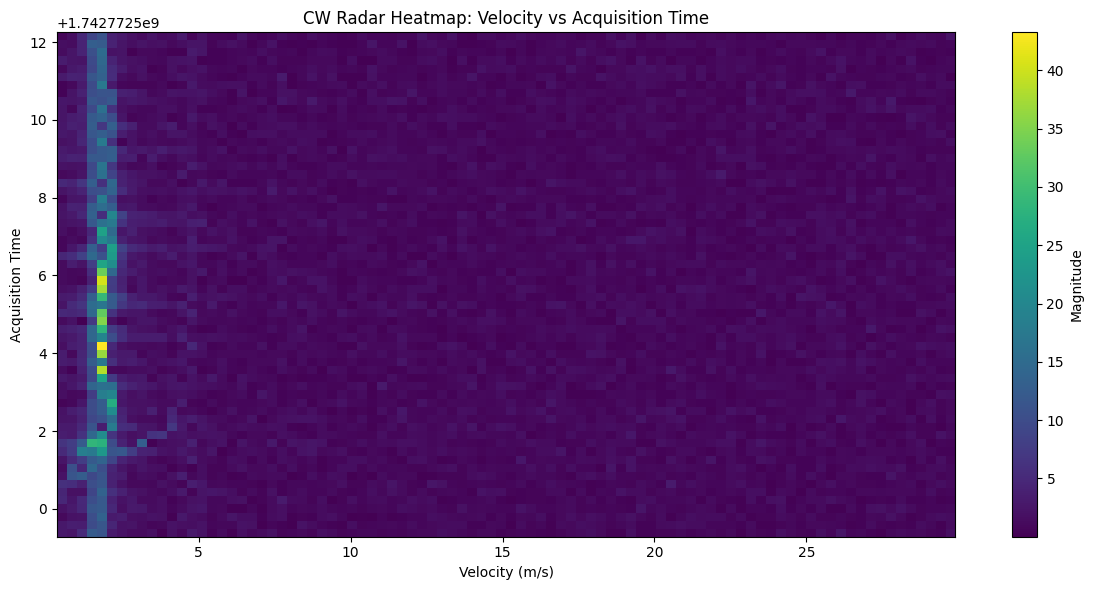

Index(['Acquisition Time', 'Reading Time', 'Channel 1', 'Channel 2'], dtype='object')


<Figure size 640x480 with 0 Axes>

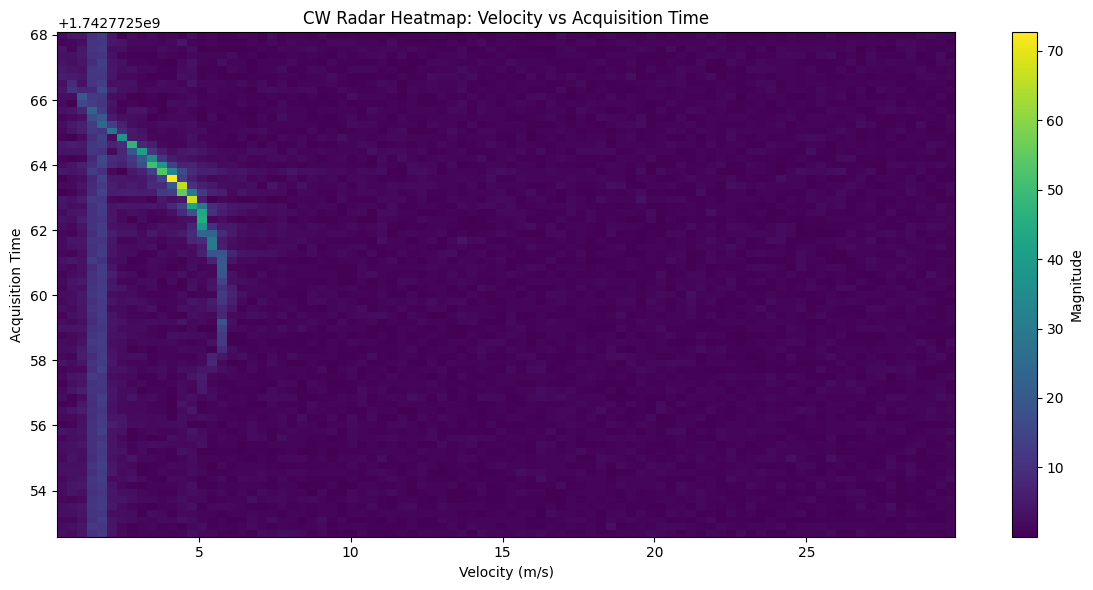

<Figure size 640x480 with 0 Axes>

In [54]:
# Read the CSV file
# df = pd.read_csv('../ductenna_backend/recordings/recording_2025-03-19_17-39-08.csv')

for file in os.listdir("../ductenna_backend/recordings"):
    if file.endswith(".csv"):
        df = pd.read_csv(f'../ductenna_backend/recordings/{file}')

        # print the column names
        print(df.columns)

        # Group by 'Acquisition Time'
        grouped = df.groupby('Acquisition Time')

        # Create a dictionary: key is the acquisition time, value is a list of rows with the other columns
        data_dict = {
            acquisition_time: group[['Reading Time', 'Channel 1', 'Channel 2']]
            for acquisition_time, group in grouped
        }

        # Prepare lists for heatmap axes
        velocities = None
        times = []
        heatmap_data = []

        # CW radar: v = (f_d * c) / (2 * fc)
        def freq_to_velocity(f_d, fc=fc, c=c):
            return (f_d * c) / (2 * fc)

        # Process each acquisition group
        for acquisition_time, data in data_dict.items():
            signal = data['Channel 2'].values  # Use 'Ch1', or change to 'CH2' if preferred

            # # Detrend or preprocess if needed
            # signal = signal - np.mean(signal)

            # Apply FFT
            fft_vals = np.fft.fft(signal)
            fft_freqs = np.fft.fftfreq(len(signal), d=np.mean(np.diff(data['Reading Time'])))

            # Only take positive frequencies
            pos_mask = fft_freqs > 0
            freqs = fft_freqs[pos_mask]
            magnitudes = np.abs(fft_vals[pos_mask])

            # Convert frequencies to velocity
            vels = freq_to_velocity(freqs)

            # Trim to cutoff velocity
            vel_mask = vels <= cutoff_velocity
            vels_trimmed = vels[vel_mask]
            mags_trimmed = magnitudes[vel_mask]

            # Store for heatmap
            if velocities is None:
                velocities = vels_trimmed
            heatmap_data.append(mags_trimmed)
            times.append(acquisition_time)

        # Create heatmap
        heatmap_array = np.array(heatmap_data)

        plt.figure(figsize=(12, 6))
        plt.imshow(
            heatmap_array,
            aspect='auto',
            extent=[min(velocities), max(velocities), min(times), max(times)],
            origin='lower'
        )
        plt.colorbar(label='Magnitude')
        plt.xlabel('Velocity (m/s)')
        plt.ylabel('Acquisition Time')
        plt.title('CW Radar Heatmap: Velocity vs Acquisition Time')
        plt.tight_layout()
        plt.show()
        # export plot to image
        plt.savefig(f'../ductenna_backend/recordings/{file}.png')
        